In [12]:
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
import torchvision

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(root='../../data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='../../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = train_dataset.classes

len(train_dataset), len(test_dataset), class_names


(60000,
 10000,
 ['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'])

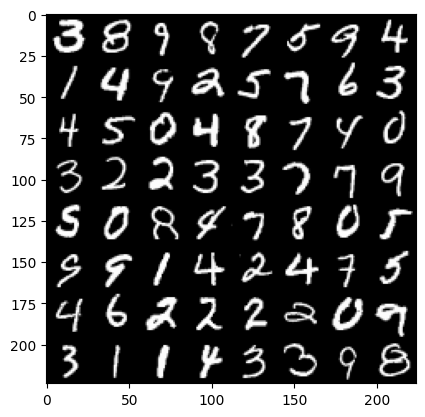

In [16]:
img, label = next(iter(train_loader))

img.shape, label
plt.imshow(np.transpose(torchvision.utils.make_grid(img, padding=0).numpy(), (1, 2, 0)))

In [3]:
def patchify(images, n_patches): 
    n, c, h, w = images.shape
    
    assert h % n_patches == 0
    
    patches = torch.zeros(n, n_patches**2, h*w*c // n_patches**2)
    patch_size = h // n_patches
    
    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
                patches[idx, i*n_patches+j] = patch.view(-1)
                
    return patches


In [17]:
class MSA(nn.Module): 
    def __init__(self, d, n_heads=2): 
        super(MSA, self).__init__()
        self.d = d
        self.n_heads = n_heads
        
        assert d % n_heads == 0
        
        d_head = int(d / n_heads)
        
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(n_heads)])
        
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        n, n_patches, d = x.shape
        
        q = torch.stack([mapping(x[:, i]) for i, mapping in enumerate(self.q_mappings)], dim=1)
        k = torch.stack([mapping(x[:, i]) for i, mapping in enumerate(self.k_mappings)], dim=1)
        v = torch.stack([mapping(x[:, i]) for i, mapping in enumerate(self.v_mappings)], dim=1)
        
        q = q.view(n, self.n_heads, n_patches, self.d_head)
        k = k.view(n, self.n_heads, n_patches, self.d_head)
        v = v.view(n, self.n_heads, n_patches, self.d_head)
        
        qk = torch.einsum('nhid,nhjd->nhij', q, k) / self.d_head**0.5
        qk = self.softmax(qk)
        
        out = torch.einsum('nhij,nhjd->nhid', qk, v)
        out = out.view(n, n_patches, self.d)
        
        return out

In [18]:
class ViTBlock(nn.Module): 
    def __init__(self, hidden_dim, n_heads, mlp_ratio=4):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_dim 
        self.n_heads = n_heads
        
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.msa = MSA(hidden_dim, n_heads)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * mlp_ratio),
            nn.ReLU(),
            nn.Linear(hidden_dim * mlp_ratio, hidden_dim)
        )
        
    def forward(self, x):
        out = x + self.msa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))        
        
        return out